In [1]:
import cv2
import tensorflow as tf
import numpy as np

# TensorFlow will use your GPU if it’s available,
# otherwise it’ll settle for the CPU (no sugar‐coating here).

# --------------------------------------------------
# Model Components
# --------------------------------------------------

class Encoder(tf.keras.layers.Layer):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()
        # A simple CNN to compress a 64x64 block into a tiny embedding
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(embedding_dim, kernel_size=3, strides=2, padding='same', activation='relu')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class HNeRVBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, upscale_factor=2, kernel_size=3):
        super(HNeRVBlock, self).__init__()
        # Mimic the conv -> PixelShuffle -> ReLU sequence.
        self.conv = tf.keras.layers.Conv2D(out_channels * (upscale_factor ** 2),
                                           kernel_size=kernel_size, padding='same')
        self.upscale_factor = upscale_factor
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        # TensorFlow’s equivalent of PixelShuffle is depth_to_space.
        x = tf.nn.depth_to_space(x, block_size=self.upscale_factor)
        return self.activation(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(Decoder, self).__init__()
        layers = []
        in_ch = embedding_dim
        # For simplicity, every block uses the same parameters.
        for _ in range(num_blocks):
            out_ch = 64
            layers.append(HNeRVBlock(in_channels=in_ch, out_channels=out_ch,
                                     upscale_factor=upscale_factor, kernel_size=3))
            in_ch = out_ch
        self.blocks = tf.keras.Sequential(layers)
        self.final_conv = tf.keras.layers.Conv2D(final_out_channels, kernel_size=3, padding='same')

    def call(self, x):
        x = self.blocks(x)
        return self.final_conv(x)

class HNeRVModel(tf.keras.Model):
    def __init__(self, in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(HNeRVModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim, num_blocks=num_blocks,
                               upscale_factor=upscale_factor, final_out_channels=final_out_channels)

    def call(self, x):
        embedding = self.encoder(x)
        return self.decoder(embedding)

# --------------------------------------------------
# Utility Functions for Block Splitting and Reconstruction
# --------------------------------------------------

def split_into_blocks(frame, block_size=64):
    """
    Splits a frame (H x W x C) into non-overlapping blocks of size block_size x block_size.
    Pads the frame if H or W are not divisible by block_size.
    Returns:
        patches: (num_blocks, block_size, block_size, C)
        n_blocks_h, n_blocks_w: number of blocks vertically/horizontally,
        pad_bottom, pad_right: amounts of padding.
    """
    # Ensure we're working on the CPU to avoid exhausting GPU memory
    with tf.device('/CPU:0'):
        # Convert frame to a Tensor if not already one
        frame = tf.convert_to_tensor(frame)
        H, W, C = frame.shape
        pad_bottom = (block_size - (H % block_size)) % block_size
        pad_right  = (block_size - (W % block_size)) % block_size
        frame_padded = tf.pad(frame, [[0, pad_bottom], [0, pad_right], [0, 0]])
        new_H, new_W, _ = frame_padded.shape
        n_blocks_h = new_H // block_size
        n_blocks_w = new_W // block_size

        # Expand dims to add the batch dimension and extract patches
        frame_expanded = tf.expand_dims(frame_padded, axis=0)  # shape: (1, H, W, C)
        patches = tf.image.extract_patches(
            images=frame_expanded,
            sizes=[1, block_size, block_size, 1],
            strides=[1, block_size, block_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Reshape patches to (num_blocks, block_size, block_size, C)
        patches = tf.reshape(patches, (n_blocks_h * n_blocks_w, block_size, block_size, C))
    return patches, n_blocks_h, n_blocks_w, pad_bottom, pad_right

def reconstruct_frame_from_blocks(blocks, n_blocks_h, n_blocks_w, block_size=64, pad_bottom=0, pad_right=0, orig_H=1080, orig_W=1920):
    """
    Reassembles blocks into a frame.
    Blocks: (num_blocks, block_size, block_size, C)
    Returns a tensor of shape (H, W, C) cropped to the original dimensions.
    """
    C = blocks.shape[-1]
    blocks_reshaped = tf.reshape(blocks, (n_blocks_h, n_blocks_w, block_size, block_size, C))
    # Rearrange to (n_blocks_h, block_size, n_blocks_w, block_size, C)
    blocks_transposed = tf.transpose(blocks_reshaped, perm=[0, 2, 1, 3, 4])
    frame_padded = tf.reshape(blocks_transposed, (n_blocks_h * block_size, n_blocks_w * block_size, C))
    return frame_padded[:orig_H, :orig_W, :]

def load_video_frames(video_path, target_resolution=(1920, 1080)):
    """
    Loads video frames from the given path and resizes them to the target_resolution.
    Returns a numpy array of shape (num_frames, H, W, C) in RGB format.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_resolution)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def save_video(frames, output_path, fps=30):
    """
    Saves a list of frames (in BGR format) to a video file.
    """
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        out_vid.write(frame)
    out_vid.release()

# --------------------------------------------------
# Main Pipeline
# --------------------------------------------------

def main():
    target_resolution = (1920, 1080)
    print("Loading video frames from './input.mp4' and resizing to 1080p...")
    frames = load_video_frames("./input.mp4", target_resolution=target_resolution)
    
    # Limit to only 50 frames (if available)
    if frames.shape[0] > 50:
        frames = frames[:50]
    num_frames, H, W, C = frames.shape
    print(f"Loaded {num_frames} frames of size {W}x{H}.")

    # Prepare the dataset: split each frame into 64x64 blocks.
    block_size = 64
    blocks_list = []
    for i in range(num_frames):
        # Convert frame to float32 and normalize to [0, 1]
        frame = frames[i].astype(np.float32) / 255.0
        patches, n_h, n_w, pad_bottom, pad_right = split_into_blocks(frame, block_size=block_size)
        blocks_list.append(patches)

    # Instead of concatenating all blocks (which can overwhelm memory), use a generator.
    def block_generator(blocks_list):
        # For each frame's blocks tensor, yield each patch as (input, target) pair.
        for patches in blocks_list:
            patches_np = patches.numpy()  # each patches is (num_blocks, block_size, block_size, 3)
            for patch in patches_np:
                yield patch, patch

    dataset = tf.data.Dataset.from_generator(
        lambda: block_generator(blocks_list),
        output_types=(tf.float32, tf.float32),
        output_shapes=((block_size, block_size, 3), (block_size, block_size, 3))
    )
    dataset = dataset.shuffle(buffer_size=1000).batch(16)

    # Initialize our HNeRV model for blocks.
    model = HNeRVModel(in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3)
    model.build(input_shape=(None, block_size, block_size, 3))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    num_epochs = 5  # Adjust this depending on how patient (or caffeinated) you are.
    print("Training on 64x64 blocks... this is where the magic (and the wait) happens.")
    model.fit(dataset, epochs=num_epochs)
    # After training, save the model to disk
    print("Saving the trained model...")
    model.save('trained_model')
    print("Model saved successfully.")
    print("Training complete. Now reconstructing full 1080p frames from blocks...")
    reconstructed_frames = []
    for i in range(num_frames):
        frame = frames[i].astype(np.float32) / 255.0
        patches, n_h, n_w, pad_bottom, pad_right = split_into_blocks(frame, block_size=block_size)
        patches_np = patches.numpy()
        # Process blocks in batches using model.predict
        recon_blocks = model.predict(patches_np, batch_size=16)
        recon_frame = reconstruct_frame_from_blocks(recon_blocks, n_h, n_w, block_size=block_size,
                                                     pad_bottom=pad_bottom, pad_right=pad_right,
                                                     orig_H=H, orig_W=W)
        # Clamp values to [0, 1] and convert to uint8
        recon_frame = np.clip(recon_frame, 0, 1)
        recon_frame = (recon_frame * 255).astype(np.uint8)
        # Convert from RGB to BGR for video saving
        recon_frame = cv2.cvtColor(recon_frame, cv2.COLOR_RGB2BGR)
        reconstructed_frames.append(recon_frame)

    output_video_path = "reconstructed_1080p.mp4"
    save_video(reconstructed_frames, output_video_path, fps=30)
    print(f"Reconstructed 1080p video saved to {output_video_path}.")

if __name__ == "__main__":
    main()


Loading video frames from './input.mp4' and resizing to 1080p...
Loaded 50 frames of size 1920x1080.
Training on 64x64 blocks... this is where the magic (and the wait) happens.
Epoch 1/5
1594/1594 [==============================] - 37s 20ms/step - loss: 0.0037
Epoch 2/5
1594/1594 [==============================] - 30s 19ms/step - loss: 4.4002e-04
Epoch 3/5
1594/1594 [==============================] - 31s 19ms/step - loss: 2.8925e-04
Epoch 4/5
1594/1594 [==============================] - 31s 19ms/step - loss: 2.6164e-04
Epoch 5/5
1594/1594 [==============================] - 31s 19ms/step - loss: 3.2331e-04
Saving the trained model...


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


Model saved successfully.
Training complete. Now reconstructing full 1080p frames from blocks...
32/32 [==============================] - 0s 6ms/step
Reconstructed 1080p video saved to reconstructed_1080p.mp4.


try 2


In [1]:
import cv2
import tensorflow as tf
import numpy as np

# --------------------------------------------------
# Model Components (unchanged)
# --------------------------------------------------

class Encoder(tf.keras.layers.Layer):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(embedding_dim, kernel_size=3, strides=2, padding='same', activation='relu')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class HNeRVBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, upscale_factor=2, kernel_size=3):
        super(HNeRVBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(out_channels * (upscale_factor ** 2),
                                           kernel_size=kernel_size, padding='same')
        self.upscale_factor = upscale_factor
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = tf.nn.depth_to_space(x, block_size=self.upscale_factor)
        return self.activation(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(Decoder, self).__init__()
        layers = []
        in_ch = embedding_dim
        for _ in range(num_blocks):
            out_ch = 64
            layers.append(HNeRVBlock(in_channels=in_ch, out_channels=out_ch,
                                     upscale_factor=upscale_factor, kernel_size=3))
            in_ch = out_ch
        self.blocks = tf.keras.Sequential(layers)
        self.final_conv = tf.keras.layers.Conv2D(final_out_channels, kernel_size=3, padding='same')

    def call(self, x):
        x = self.blocks(x)
        return self.final_conv(x)

class HNeRVModel(tf.keras.Model):
    def __init__(self, in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(HNeRVModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim, num_blocks=num_blocks,
                               upscale_factor=upscale_factor, final_out_channels=final_out_channels)

    def call(self, x):
        embedding = self.encoder(x)
        return self.decoder(embedding)

# --------------------------------------------------
# Utility Functions (unchanged)
# --------------------------------------------------

def split_into_blocks(frame, block_size=64):
    with tf.device('/CPU:0'):
        frame = tf.convert_to_tensor(frame)
        H, W, C = frame.shape
        pad_bottom = (block_size - (H % block_size)) % block_size
        pad_right  = (block_size - (W % block_size)) % block_size
        frame_padded = tf.pad(frame, [[0, pad_bottom], [0, pad_right], [0, 0]])
        new_H, new_W, _ = frame_padded.shape
        n_blocks_h = new_H // block_size
        n_blocks_w = new_W // block_size
        frame_expanded = tf.expand_dims(frame_padded, axis=0)
        patches = tf.image.extract_patches(
            images=frame_expanded,
            sizes=[1, block_size, block_size, 1],
            strides=[1, block_size, block_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, (n_blocks_h * n_blocks_w, block_size, block_size, C))
    return patches, n_blocks_h, n_blocks_w, pad_bottom, pad_right

def reconstruct_frame_from_blocks(blocks, n_blocks_h, n_blocks_w, block_size=64, pad_bottom=0, pad_right=0, orig_H=1080, orig_W=1920):
    C = blocks.shape[-1]
    blocks_reshaped = tf.reshape(blocks, (n_blocks_h, n_blocks_w, block_size, block_size, C))
    blocks_transposed = tf.transpose(blocks_reshaped, perm=[0, 2, 1, 3, 4])
    frame_padded = tf.reshape(blocks_transposed, (n_blocks_h * block_size, n_blocks_w * block_size, C))
    return frame_padded[:orig_H, :orig_W, :]

def load_video_frames(video_path, target_resolution=(1920, 1080)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_resolution)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def save_video(frames, output_path, fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        out_vid.write(frame)
    out_vid.release()

# --------------------------------------------------
# Main Pipeline (FIXED workflow)
# --------------------------------------------------

def main():
    # Load and prepare data
    target_resolution = (1920, 1080)
    print("Loading video frames...")
    frames = load_video_frames("./input.mp4", target_resolution)
    if frames.shape[0] > 50:  # Limit to 50 frames
        frames = frames[:50]
    num_frames, H, W, C = frames.shape
    print(f"Loaded {num_frames} frames of size {W}x{H}.")

    # Prepare dataset (split into 64x64 blocks)
    block_size = 64
    blocks_list = []
    for i in range(num_frames):
        frame = frames[i].astype(np.float32) / 255.0
        patches, _, _, _, _ = split_into_blocks(frame, block_size)
        blocks_list.append(patches)

    # Create TensorFlow dataset
    def block_generator():
        for patches in blocks_list:
            patches_np = patches.numpy()
            for patch in patches_np:
                yield patch, patch  # (input, target)

    dataset = tf.data.Dataset.from_generator(
        block_generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=((64, 64, 3), (64, 64, 3))
    ).shuffle(1000).batch(16)

    # Initialize and train model
    model = HNeRVModel()
    model.compile(optimizer='adam', loss='mse')
    print("Training model...")
    model.fit(dataset, epochs=5)
    model.save('trained_model')
    print("Model trained and saved.")

    # Generate and save latent representations USING TRAINED ENCODER
    print("Generating latent representations...")
    latent_representations = []
    for i in range(num_frames):
        frame = frames[i].astype(np.float32) / 255.0
        patches, n_h, n_w, pad_b, pad_r = split_into_blocks(frame, block_size)
        latent = model.encoder(patches.numpy())  # Use trained encoder
        latent_representations.append({
            'latent': latent.numpy(),
            'n_blocks_h': n_h,
            'n_blocks_w': n_w,
            'pad_bottom': pad_b,
            'pad_right': pad_r
        })
    np.save("latents.npy", latent_representations)
    print("Latents saved to latents.npy")

    # Reconstruct from saved latents USING TRAINED DECODER
    print("Reconstructing video...")
    latents_data = np.load("latents.npy", allow_pickle=True)
    reconstructed_frames = []
    for frame_data in latents_data:
        latent = tf.convert_to_tensor(frame_data['latent'], dtype=tf.float32)
        recon_blocks = model.decoder(latent)  # Use trained decoder
        recon_frame = reconstruct_frame_from_blocks(
            recon_blocks,
            frame_data['n_blocks_h'],
            frame_data['n_blocks_w'],
            block_size=64,
            pad_bottom=frame_data['pad_bottom'],
            pad_right=frame_data['pad_right'],
            orig_H=H,
            orig_W=W
        )
        recon_frame = (recon_frame.numpy() * 255).astype(np.uint8)
        recon_frame = cv2.cvtColor(recon_frame, cv2.COLOR_RGB2BGR)
        reconstructed_frames.append(recon_frame)

    save_video(reconstructed_frames, "reconstructed_video.mp4", fps=30)
    print("Reconstruction complete!")

if __name__ == "__main__":
    main()

Loading video frames...
Loaded 50 frames of size 1920x1080.
Training model...
Epoch 1/5
1594/1594 [==============================] - 37s 19ms/step - loss: 0.0063
Epoch 2/5
1594/1594 [==============================] - 30s 19ms/step - loss: 4.0851e-04
Epoch 3/5
1594/1594 [==============================] - 31s 19ms/step - loss: 2.3797e-04
Epoch 4/5
1594/1594 [==============================] - 31s 19ms/step - loss: 2.3864e-04
Epoch 5/5
1594/1594 [==============================] - 30s 19ms/step - loss: 2.8800e-04


INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


Model trained and saved.
Generating latent representations...
Latents saved to latents.npy
Reconstructing video...
Reconstruction complete!


# try 3 importannnnnnnnnnnnt!!!


In [1]:
import cv2
import tensorflow as tf
import numpy as np

# --------------------------------------------------
# Model Components (modified for correct upsampling)
# --------------------------------------------------

class Encoder(tf.keras.layers.Layer):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(embedding_dim, kernel_size=3, strides=2, padding='same', activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

class HNeRVBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, upscale_factor=2, kernel_size=3):
        super(HNeRVBlock, self).__init__()
        self.upscale_factor = upscale_factor
        
        self.conv = tf.keras.layers.Conv2D(
            out_channels * (upscale_factor ** 2),
            kernel_size=kernel_size,
            padding='same'
        )
        
        self.skip_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(out_channels, kernel_size=1, padding='same'),
            tf.keras.layers.UpSampling2D(size=upscale_factor)
        ])
        
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x_main = self.conv(x)
        x_main = tf.nn.depth_to_space(x_main, block_size=self.upscale_factor)
        x_skip = self.skip_conv(x)
        return self.activation(x_main + x_skip)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim=64, num_blocks=4, upscale_factor=2, final_out_channels=3):
        super(Decoder, self).__init__()
        layers = []
        in_ch = embedding_dim
        
        # Adjusted channel progression for 4 blocks
        for i in range(num_blocks):
            current_upscale = 2  # All blocks use upscale factor 2
            # Channel progression: 64 -> 128 -> 128 -> 64 -> 64
            out_ch = 128 if i < 2 else 64
            layers.append(HNeRVBlock(
                in_channels=in_ch,
                out_channels=out_ch,
                upscale_factor=current_upscale,
                kernel_size=3
            ))
            in_ch = out_ch
            
        self.blocks = tf.keras.Sequential(layers)
        self.final_conv = tf.keras.layers.Conv2D(
            final_out_channels, 
            kernel_size=3, 
            padding='same', 
            activation='sigmoid'
        )

    def call(self, x):
        x = self.blocks(x)
        return self.final_conv(x)

class HNeRVModel(tf.keras.Model):
    def __init__(self, in_channels=3, embedding_dim=64, num_blocks=4, upscale_factor=2, final_out_channels=3):  # Fixed default num_blocks
        super(HNeRVModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim, num_blocks=num_blocks,
                               upscale_factor=upscale_factor, final_out_channels=final_out_channels)

    def call(self, x):
        embedding = self.encoder(x)
        return self.decoder(embedding)

# --------------------------------------------------
# Utility Functions (unchanged)
# --------------------------------------------------

def split_into_blocks(frame, block_size=64):
    with tf.device('/CPU:0'):
        frame = tf.convert_to_tensor(frame)
        H, W, C = frame.shape
        pad_bottom = (block_size - (H % block_size)) % block_size
        pad_right  = (block_size - (W % block_size)) % block_size
        frame_padded = tf.pad(frame, [[0, pad_bottom], [0, pad_right], [0, 0]])
        new_H, new_W, _ = frame_padded.shape
        n_blocks_h = new_H // block_size
        n_blocks_w = new_W // block_size
        frame_expanded = tf.expand_dims(frame_padded, axis=0)
        patches = tf.image.extract_patches(
            images=frame_expanded,
            sizes=[1, block_size, block_size, 1],
            strides=[1, block_size, block_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, (n_blocks_h * n_blocks_w, block_size, block_size, C))
    return patches, n_blocks_h, n_blocks_w, pad_bottom, pad_right

def reconstruct_frame_from_blocks(blocks, n_blocks_h, n_blocks_w, block_size=64, pad_bottom=0, pad_right=0, orig_H=1080, orig_W=1920):
    C = blocks.shape[-1]
    blocks_reshaped = tf.reshape(blocks, (n_blocks_h, n_blocks_w, block_size, block_size, C))
    blocks_transposed = tf.transpose(blocks_reshaped, perm=[0, 2, 1, 3, 4])
    frame_padded = tf.reshape(blocks_transposed, (n_blocks_h * block_size, n_blocks_w * block_size, C))
    return frame_padded[:orig_H, :orig_W, :]

def load_video_frames(video_path, target_resolution=(1920, 1080)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_resolution)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def save_video(frames, output_path, fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        out_vid.write(frame)
    out_vid.release()

# --------------------------------------------------
# Main Pipeline (critical fix in model initialization)
# --------------------------------------------------

def main():
    # Load and prepare data
    target_resolution = (1920, 1080)
    print("Loading video frames...")
    frames = load_video_frames("./input.mp4", target_resolution)
    if frames.shape[0] > 50:
        frames = frames[:50]
    num_frames, H, W, C = frames.shape
    print(f"Loaded {num_frames} frames of size {W}x{H}.")

    # Prepare dataset
    block_size = 64
    blocks_list = []
    for i in range(num_frames):
        frame = frames[i].astype(np.float32) / 255.0
        patches, _, _, _, _ = split_into_blocks(frame, block_size)
        blocks_list.append(patches)

    # Create TensorFlow dataset
    def block_generator():
        for patches in blocks_list:
            patches_np = patches.numpy()
            for patch in patches_np:
                yield patch, patch

    dataset = tf.data.Dataset.from_generator(
        block_generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=((64, 64, 3), (64, 64, 3))
    ).shuffle(1000).batch(16)

    # Initialize model with CORRECT number of decoder blocks
    model = HNeRVModel(num_blocks=4)  # Critical fix: 4 blocks for 64x64 output
    model.compile(optimizer='adam', loss='mse')
    print("Training model...")
    model.fit(dataset, epochs=100)
    model.save('trained_model')
    print("Model trained and saved.")

    # Generate latent video
    print("Generating and saving compressed video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    compressed_vid = cv2.VideoWriter('compressed.mp4', fourcc, 30, (240, 135))
    original_height = H
    original_width = W

    for i in range(num_frames):
        frame = frames[i].astype(np.float32) / 255.0
        patches, n_blocks_h, n_blocks_w, pad_bottom, pad_right = split_into_blocks(frame, block_size)
        latent = model.encoder(patches.numpy()).numpy()

        grid = np.zeros((n_blocks_h * 8, n_blocks_w * 8, 3), dtype=np.uint8)
        block_idx = 0
        for row in range(n_blocks_h):
            for col in range(n_blocks_w):
                block_data = (latent[block_idx] * 255).astype(np.uint8)
                grid[row*8:(row+1)*8, col*8:(col+1)*8, :] = block_data
                block_idx += 1

        resized_grid = cv2.resize(grid, (240, 135), interpolation=cv2.INTER_LINEAR)
        resized_grid_bgr = cv2.cvtColor(resized_grid, cv2.COLOR_RGB2BGR)
        compressed_vid.write(resized_grid_bgr)
    compressed_vid.release()
    print("Compressed video saved as compressed.mp4")

    # Decode from compressed video
    print("Reconstructing video from compressed data...")
    cap = cv2.VideoCapture('compressed.mp4')
    reconstructed_frames = []

    block_size = 64
    n_blocks_w = original_width // block_size
    padded_width = n_blocks_w * block_size
    n_blocks_h = (original_height + block_size - 1) // block_size
    padded_height = n_blocks_h * block_size
    pad_bottom = padded_height - original_height
    pad_right = padded_width - original_width

    while True:
        ret, compressed_frame = cap.read()
        if not ret:
            break
        compressed_frame_rgb = cv2.cvtColor(compressed_frame, cv2.COLOR_BGR2RGB)
        
        target_grid_height = n_blocks_h * 8
        target_grid_width = n_blocks_w * 8
        resized_grid = cv2.resize(compressed_frame_rgb, (target_grid_width, target_grid_height), interpolation=cv2.INTER_LINEAR)
        
        blocks = []
        for row in range(n_blocks_h):
            for col in range(n_blocks_w):
                block = resized_grid[row*8:(row+1)*8, col*8:(col+1)*8, :]
                blocks.append(block)
        
        blocks = np.array(blocks, dtype=np.float32) / 255.0
        decoded_blocks = model.decoder(blocks).numpy()
        
        recon_frame = reconstruct_frame_from_blocks(
            decoded_blocks,
            n_blocks_h,
            n_blocks_w,
            block_size=64,
            pad_bottom=pad_bottom,
            pad_right=pad_right,
            orig_H=original_height,
            orig_W=original_width
        )
        recon_frame = (recon_frame.numpy() * 255).astype(np.uint8)
        recon_frame_bgr = cv2.cvtColor(recon_frame, cv2.COLOR_RGB2BGR)
        reconstructed_frames.append(recon_frame_bgr)
    
    cap.release()
    save_video(reconstructed_frames, "reconstructed_video.mp4", fps=30)
    print("Reconstruction complete!")

if __name__ == "__main__":
    main()

Loading video frames...
Loaded 50 frames of size 1920x1080.
Training model...
Epoch 1/100
1594/1594 [==============================] - 57s 32ms/step - loss: 0.0030
Epoch 2/100
1594/1594 [==============================] - 50s 32ms/step - loss: 5.8754e-04
Epoch 3/100
1594/1594 [==============================] - 50s 31ms/step - loss: 4.5314e-04
Epoch 4/100
1594/1594 [==============================] - 50s 31ms/step - loss: 3.9457e-04
Epoch 5/100
1594/1594 [==============================] - 50s 31ms/step - loss: 3.6733e-04
Epoch 6/100
1594/1594 [==============================] - 50s 31ms/step - loss: 4.1688e-04
Epoch 7/100
1594/1594 [==============================] - 50s 31ms/step - loss: 2.5579e-04
Epoch 8/100
1594/1594 [==============================] - 49s 31ms/step - loss: 2.5245e-04
Epoch 9/100
1594/1594 [==============================] - 53s 33ms/step - loss: 2.0933e-04
Epoch 10/100
1594/1594 [==============================] - 52s 32ms/step - loss: 2.1298e-04
Epoch 11/100
1594/1594 [=

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


Model trained and saved.
Generating and saving compressed video...


ValueError: could not broadcast input array from shape (4,4,64) into shape (8,8,3)

# frame reconstruction

Model weights loaded successfully.
1/1 [==============================] - 0s 24ms/step


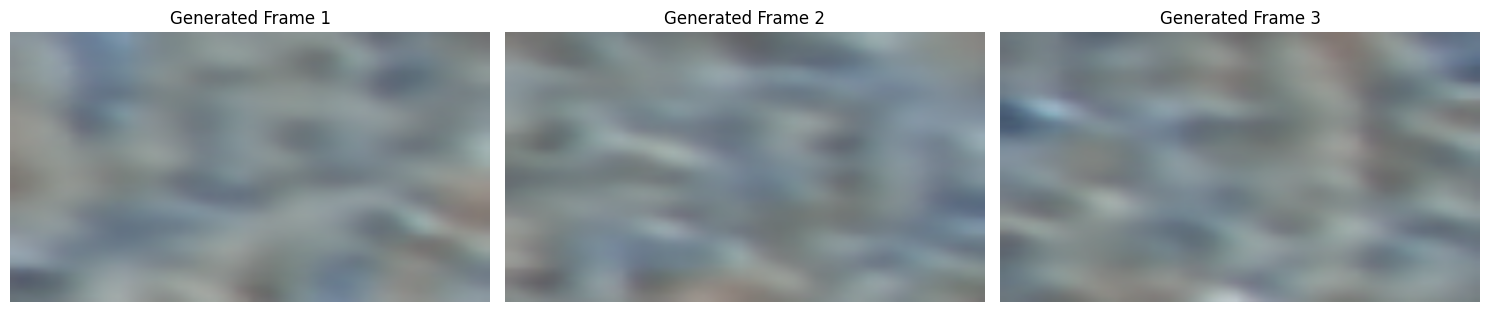

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Model Components (same as during training)
# --------------------------------------------------

class Encoder(tf.keras.layers.Layer):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(embedding_dim, kernel_size=3, strides=2, padding='same', activation='relu')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class HNeRVBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, upscale_factor=2, kernel_size=3):
        super(HNeRVBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(out_channels * (upscale_factor ** 2),
                                           kernel_size=kernel_size, padding='same')
        self.upscale_factor = upscale_factor
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = tf.nn.depth_to_space(x, block_size=self.upscale_factor)
        return self.activation(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(Decoder, self).__init__()
        layers = []
        in_ch = embedding_dim
        for _ in range(num_blocks):
            out_ch = 64
            layers.append(HNeRVBlock(in_channels=in_ch, out_channels=out_ch,
                                     upscale_factor=upscale_factor, kernel_size=3))
            in_ch = out_ch
        self.blocks = tf.keras.Sequential(layers)
        self.final_conv = tf.keras.layers.Conv2D(final_out_channels, kernel_size=3, padding='same')

    def call(self, x):
        x = self.blocks(x)
        return self.final_conv(x)

class HNeRVModel(tf.keras.Model):
    def __init__(self, in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(HNeRVModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim, num_blocks=num_blocks,
                               upscale_factor=upscale_factor, final_out_channels=final_out_channels)

    def call(self, x):
        embedding = self.encoder(x)
        return self.decoder(embedding)

# --------------------------------------------------
# Function to Generate Random Frames
# --------------------------------------------------

def generate_random_frames(model, num_frames=3, block_size=64, frame_height=1080, frame_width=1920):
    """
    Generates random frames using the trained model.
    Args:
        model: The trained HNeRV model.
        num_frames: Number of random frames to generate.
        block_size: Size of the input block (default: 64x64).
        frame_height: Height of the output frame.
        frame_width: Width of the output frame.
    Returns:
        frames: List of generated frames (as numpy arrays).
    """
    frames = []
    for _ in range(num_frames):
        # Generate random input (e.g., random noise or embeddings)
        random_input = np.random.rand(1, block_size, block_size, 3).astype(np.float32)  # Random input of shape (1, 64, 64, 3)

        # Pass the input through the model to generate a frame
        generated_frame = model.predict(random_input)

        # Reshape and post-process the output
        generated_frame = np.squeeze(generated_frame)  # Remove batch dimension
        generated_frame = np.clip(generated_frame, 0, 1)  # Clamp values to [0, 1]
        generated_frame = (generated_frame * 255).astype(np.uint8)  # Convert to uint8

        # Resize the frame to the target resolution (if needed)
        if generated_frame.shape[0] != frame_height or generated_frame.shape[1] != frame_width:
            generated_frame = cv2.resize(generated_frame, (frame_width, frame_height))

        frames.append(generated_frame)

    return frames

# --------------------------------------------------
# Load Weights, Rebuild Model, and Generate Frames
# --------------------------------------------------

def load_and_generate_frames(weights_path, num_frames=3):
    """
    Loads the model weights, rebuilds the model, and generates random frames.
    Args:
        weights_path: Path to the saved model weights.
        num_frames: Number of random frames to generate.
    """
    # Rebuild the model architecture
    model = HNeRVModel(in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3)
    model.build(input_shape=(None, 64, 64, 3))  # Build the model with the expected input shape

    # Load the saved weights
    model.load_weights(weights_path)
    print("Model weights loaded successfully.")

    # Generate random frames
    random_frames = generate_random_frames(model, num_frames=num_frames)

    # Display the generated frames using matplotlib
    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(random_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.title(f'Generated Frame {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# Main Execution
# --------------------------------------------------

if __name__ == "__main__":
    # Path to the saved weights
    weights_path = 'trained_model_weights.h5'

    # Load weights, rebuild model, and generate frames
    load_and_generate_frames(weights_path, num_frames=3)

In [4]:
import cv2
import tensorflow as tf
import numpy as np

# --------------------------------------------------
# Model Components (same as during training)
# --------------------------------------------------

class Encoder(tf.keras.layers.Layer):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(embedding_dim, kernel_size=3, strides=2, padding='same', activation='relu')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class HNeRVBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, upscale_factor=2, kernel_size=3):
        super(HNeRVBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(out_channels * (upscale_factor ** 2),
                                           kernel_size=kernel_size, padding='same')
        self.upscale_factor = upscale_factor
        self.activation = tf.keras.layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = tf.nn.depth_to_space(x, block_size=self.upscale_factor)
        return self.activation(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(Decoder, self).__init__()
        layers = []
        in_ch = embedding_dim
        for _ in range(num_blocks):
            out_ch = 64
            layers.append(HNeRVBlock(in_channels=in_ch, out_channels=out_ch,
                                     upscale_factor=upscale_factor, kernel_size=3))
            in_ch = out_ch
        self.blocks = tf.keras.Sequential(layers)
        self.final_conv = tf.keras.layers.Conv2D(final_out_channels, kernel_size=3, padding='same')

    def call(self, x):
        x = self.blocks(x)
        return self.final_conv(x)

class HNeRVModel(tf.keras.Model):
    def __init__(self, in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3):
        super(HNeRVModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim, num_blocks=num_blocks,
                               upscale_factor=upscale_factor, final_out_channels=final_out_channels)

    def call(self, x):
        embedding = self.encoder(x)
        return self.decoder(embedding)

# --------------------------------------------------
# Function to Generate Video from Model Weights
# --------------------------------------------------

def generate_video_from_weights(weights_path, output_video_path, num_frames=50, frame_height=1080, frame_width=1920, block_size=64, fps=30):
    """
    Generates a video using the saved model weights.
    Args:
        weights_path: Path to the saved model weights.
        output_video_path: Path to save the generated video.
        num_frames: Number of frames to generate.
        frame_height: Height of the output video frames.
        frame_width: Width of the output video frames.
        block_size: Size of the input block (default: 64x64).
        fps: Frames per second of the output video.
    """
    # Rebuild the model architecture
    model = HNeRVModel(in_channels=3, embedding_dim=64, num_blocks=3, upscale_factor=2, final_out_channels=3)
    model.build(input_shape=(None, block_size, block_size, 3))  # Build the model with the expected input shape

    # Load the saved weights
    model.load_weights(weights_path)
    print("Model weights loaded successfully.")

    # Generate frames
    frames = []
    for _ in range(num_frames):
        # Generate random input (e.g., random noise or embeddings)
        random_input = np.random.rand(1, block_size, block_size, 3).astype(np.float32)  # Random input of shape (1, 64, 64, 3)

        # Pass the input through the model to generate a frame
        generated_frame = model.predict(random_input)

        # Reshape and post-process the output
        generated_frame = np.squeeze(generated_frame)  # Remove batch dimension
        generated_frame = np.clip(generated_frame, 0, 1)  # Clamp values to [0, 1]
        generated_frame = (generated_frame * 255).astype(np.uint8)  # Convert to uint8

        # Resize the frame to the target resolution (if needed)
        if generated_frame.shape[0] != frame_height or generated_frame.shape[1] != frame_width:
            generated_frame = cv2.resize(generated_frame, (frame_width, frame_height))

        # Convert from RGB to BGR for video saving
        generated_frame = cv2.cvtColor(generated_frame, cv2.COLOR_RGB2BGR)
        frames.append(generated_frame)

    # Save the frames as a video
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    for frame in frames:
        out_vid.write(frame)
    out_vid.release()

    print(f"Generated video saved to {output_video_path}.")

# --------------------------------------------------
# Main Execution
# --------------------------------------------------

if __name__ == "__main__":
    # Path to the saved weights
    weights_path = 'trained_model_weights.h5'

    # Path to save the generated video
    output_video_path = 'generated_video.mp4'

    # Generate video from the saved weights
    generate_video_from_weights(weights_path, output_video_path, num_frames=50, fps=30)

Model weights loaded successfully.
1/1 [==============================] - 0s 23ms/step
Generated video saved to generated_video.mp4.


# pruning + quantization

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np

# Load the pre-trained model from disk
model_path = 'trained_model.h5'  # Replace with your model path
model = tf.keras.models.load_model(model_path)

# Define pruning configuration
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

# Apply pruning to the loaded model
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
model_for_pruning.compile(optimizer='adam', loss='mse')

# Fine-tune the pruned model (optional but recommended)
# Use your actual dataset here. For demonstration, we use dummy data.
dummy_data = np.random.rand(100, 64, 64, 3).astype(np.float32)
dummy_labels = np.random.rand(100, 64, 64, 3).astype(np.float32)
model_for_pruning.fit(dummy_data, dummy_labels, epochs=2, batch_size=16)

# Strip pruning wrappers and save the pruned model
final_pruned_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
final_pruned_model.save('pruned_model.h5')

# Apply post-training quantization to the pruned model
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply default quantization
quantized_tflite_model = converter.convert()

# Save the quantized model
quantized_model_path = 'quantized_pruned_model.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Pruned and quantized model saved as '{quantized_model_path}'.")